#### Copia de testing_crpss+int_TreeCorr.ipynb
### Calcular CrossCorrelation con boostrap para suavizar curvas e integrar sólo donde todas sean positivas

In [5]:
######################
minsep = 10.      # Min theta
maxsep = 90.      # Max theta
nbins = 15        # Bins in theta
nmult = 50        # nmult := Nr/Nd
npatch = 50
nbootstrap = 500  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
nquant = 4       # No. of quantiles to split sample in Mag_K
cutoff = 6        # Ignore the 'cutoff' no. of last bins for integration

seed1 = 12936
seed2 = 19284

sample = 'passivecrop'
write = False
plot = False
config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            "var_method": 'bootstrap', \
            "num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if sample=='passivecrop': filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
elif sample=='sinAGNWISE': filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISE.txt'
elif sample=='sinAGNWISEniBPT': filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
gxs = ascii.read(filename_g)

# Bright/Faint
quantiles = np.quantile(gxs['K_abs'],np.linspace(0,1,nquant+1))

data = []

for q in range(nquant):
  data.append(

    gxs[(gxs['K_abs']>quantiles[q])&(gxs['K_abs']<quantiles[q+1])]

  )


In [6]:
import treecorr


# TreeCorr Catalogues


rcat = []
for q in range(nquant):
    rand_ra, rand_dec = generate_RandomCatalogue(data[q]['_RAJ2000'],data[q]['_DEJ2000'],\
                                               nmult, mask=True)
    rcat.append(treecorr.Catalog(ra=rand_ra, dec=rand_dec, \
                        ra_units='deg', dec_units='deg', npatch=npatch))

xi_bs = []
varxi_bs = []
for q in range(nquant):

    xi_bs = np.zeros((nbootstrap,nbins))
    varxi_bs = np.zeros((nbootstrap,nbins))

    dd = treecorr.NNCorrelation(config)
    dr = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)
    rd = treecorr.NNCorrelation(config)

    #for n in range(nbootstrap):
    #databs = np.random.choice(data,size=len(data))
    gcat = treecorr.Catalog(ra=data[q]['_RAJ2000'], dec=data[q]['_DEJ2000'],\
                            ra_units='deg', dec_units='deg', npatch=npatch)
    ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg', patch_centers=gcat.patch_centers)
    
    rr.process(rcat[q])
    dd.process(gcat,ecat)
    dr.process(gcat,rcat[q])
    rd.process(ecat,rcat[q])

    xi_bs[q], varxi_bs[q] = dd.calculateXi(rr=rr,dr=dr,rd=rd)

    #results =  get_xibs(data[q],nbootstrap,nbins,rcat[q],ecat,config) 
    #xi_bs.append(results[0])
    #varxi_bs.append(results[1])
    print(q+1,'/',nquant)
th = dd.meanr


1 / 4
2 / 4
3 / 4
4 / 4


#### Plot

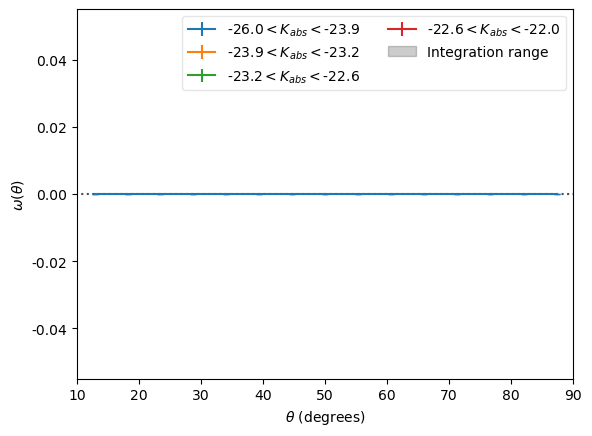

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)
fillalpha=.2
#xi1_max = [np.max(xi_bs[0][:,i]) for i in range(nbins)][:-cutoff]
#ax.fill_between(th[:-cutoff], y1=np.max(xi1_max), color='k', alpha=fillalpha)

alpha=1
capsize = 2
labels = []
for q in range(nquant):
    labels.append(
         f'{quantiles[q]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[q+1]:.1f}'
    )

c = ['C00','C01','C02','C03','C04','C05']
for q in range(1):
        line = ax.errorbar(th, xi_bs[q], yerr=np.sqrt(varxi_bs[q]), \
                    color=c[q], label=labels[q],\
                    alpha=alpha, capsize=capsize)

#Legend
handles = [plt.errorbar([],[],yerr=1,color=c[i]) for i in range(nquant)]#,\
handles.append(plt.fill_between([],[],color='k',alpha=fillalpha))
labels_ = [labels[i] for i in range(nquant)]
labels_.append('Integration range')
plt.legend(handles, labels_, loc=1, fancybox=True, framealpha=0.5, ncol=2)


ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# if plot==True:
#     plotname = f'../data/cross_treecorr_nq{nquant}_nmult{nmult}_nbs{nbootstrap}'
#     plotname += f'_{sample}'
#     print('Saving',plotname)
#     plt.savefig(plotname+'.png')

plt.show()


#### Integration

In [4]:
from scipy import integrate

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        int[q][i] = integrate.trapezoid( xi_bs[q][i][:-cutoff],x=th[:-cutoff], dx=1.)
        #int[q][i] = integrate.trapezoid(  np.sin(np.deg2rad(th[:-cutoff])) * xi_bs[q][i][:-cutoff],x=th[:-cutoff])


ratio_mean = np.zeros(nquant)
std_mean = np.zeros(nquant)

for q in range(nquant):
    ratio_mean[q] = np.mean(int[q])/np.mean(int[0])
    std_mean[q] = np.std(int[q])/np.mean(int[0])


#### Plot cocientes

[1.         0.44100755 0.24581093 0.1426891 ] [1.         0.71115824 0.2551276  0.10869562]


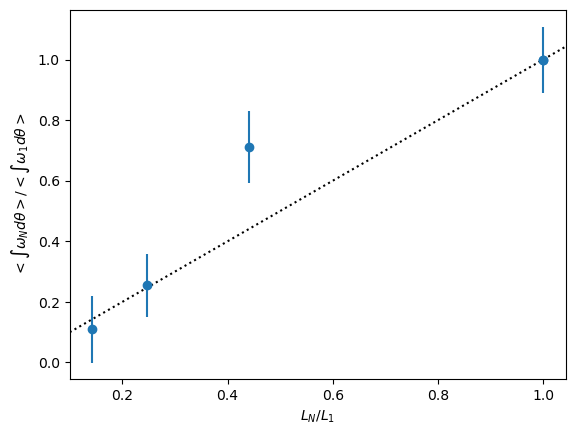

In [5]:
fig, ax = plt.subplots()

meanMag = np.zeros(nquant)
for q in range(nquant):
    meanMag[q] = np.mean(data[q]['K_abs'])


L_ratio = np.zeros(nquant)
for q in range(nquant):
    L_ratio[q] = 10**(-.4*(meanMag[q]-meanMag[0]))

print(L_ratio,ratio_mean)

ax.scatter(1,1,c='C00')
for i in range(len(ratio_mean)):
    ax.errorbar(L_ratio[i],ratio_mean[i],yerr=std_mean[i],c='C00',fmt='o')
#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)
ax.axline((1,1),slope=1,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_Nd\theta>/<\int\omega_1d\theta>$')
ax.set_xlabel(r'$L_N/L_1$')

plotname = f'int_L_nquant{nquant}_nbs{nbootstrap}.png'
#plt.savefig('../plots/'+plotname)

plt.show()

#### Write

In [6]:
filename = f'../data/int_L_nq{nquant}_nbs{nbootstrap}_{sample}.npz'
names = ['int_ratio','L_ratio','int_std']

print(filename)
ascii.write(np.column_stack([ratio_mean,L_ratio,std_mean]),filename,names=names,overwrite=True)

../data/int_L_nq4_nbs100_passivecrop.npz


# EXTRAS

### Probar Spline integration

In [7]:
import numpy as np
from scipy.interpolate import UnivariateSpline
x = np.linspace(0, 3, 11)
y = np.cos(x)
spl = UnivariateSpline(x, y)
print(spl.integral(0, 3))

y = x**3
spl2 = UnivariateSpline(x, y)
print(spl2.integral(0,3))

print(spl.integral(0, 3)/spl2.integral(0,3))


0.14183063888352976
20.249999999999996
0.00700398216708789


In [8]:
from scipy import integrate

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        spl = UnivariateSpline(th[:-cutoff],np.sin(np.deg2rad(th[:-cutoff]))*xi_bs[q][i][:-cutoff])
        int[q][i] = spl.integral(10.,70.)

ratio_mean = np.zeros(nquant)
std_mean = np.zeros(nquant)

for q in range(nquant):
    ratio_mean[q] = np.mean(int[q])/np.mean(int[0])
    std_mean[q] = np.std(int[q])/np.mean(int[0])

[1.         0.44100755 0.24581093 0.1426891 ] [1.         0.6992632  0.23913968 0.10339033]


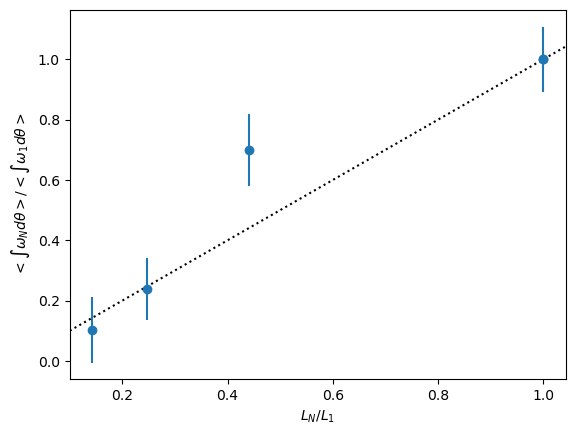

In [9]:
fig, ax = plt.subplots()

meanMag = np.zeros(nquant)
for q in range(nquant):
    meanMag[q] = np.mean(data[q]['K_abs'])


L_ratio = np.zeros(nquant)
for q in range(nquant):
    L_ratio[q] = 10**(-.4*(meanMag[q]-meanMag[0]))

print(L_ratio,ratio_mean)

ax.scatter(1,1,c='C00')
for i in range(len(ratio_mean)):
    ax.errorbar(L_ratio[i],ratio_mean[i],yerr=std_mean[i],c='C00',fmt='o')
#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)
ax.axline((1,1),slope=1,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_Nd\theta>/<\int\omega_1d\theta>$')
ax.set_xlabel(r'$L_N/L_1$')

plotname = f'int_L_nquant{nquant}_nbs{nbootstrap}.png'
#plt.savefig('../plots/'+plotname)

plt.show()

### Plot sin cocientes

11.319325033604086


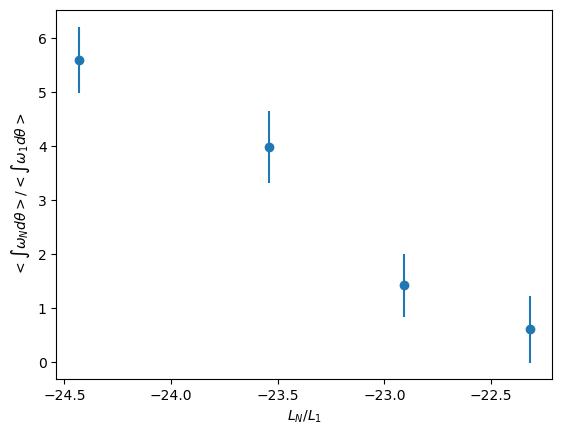

In [10]:
from scipy import integrate

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        int[q][i] = integrate.trapezoid( xi_bs[q][i][:-cutoff],x=th[:-cutoff], dx=1.)
        #int[q][i] = integrate.trapezoid(  np.sin(np.deg2rad(th[:-cutoff])) * xi_bs[q][i][:-cutoff],x=th[:-cutoff])


int_mean = np.zeros(nquant)
int_std = np.zeros(nquant)
for q in range(nquant):
    int_mean[q] = np.mean(int[q])
    int_std[q] = np.std(int[q])

fig, ax = plt.subplots()

meanMag = np.zeros(nquant)
for q in range(nquant):
    meanMag[q] = np.mean(data[q]['K_abs'])


L = np.zeros(nquant)
for q in range(nquant):
    L[q] = 10**(-.4*(meanMag[q]-meanMag[0]))

#print(L_ratio,ratio_mean)

#ax.scatter(1,1,c='C00')
for i in range(len(int)):
    ax.errorbar(meanMag[i],int_mean[i],yerr=int_std[i],c='C00',fmt='o')
#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)

slope=((int_mean[1]-int_mean[-1])/(L[1]-L[-1]))
print(slope)

#ax.axline((L[-1],int_mean[-1]),slope=slope,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_Nd\theta>/<\int\omega_1d\theta>$')
ax.set_xlabel(r'$L_N/L_1$')


plotname = f'int_L_nquant{nquant}_nbs{nbootstrap}.png'
#plt.savefig('../plots/'+plotname)

plt.show()


In [11]:
slope3=11.174427769468721
slope6=11.847546962522127


### Cocientes intermedios

#### PARA NQUANT=4

[0.44100755 0.24581093 0.1426891 ] [0.71115824 0.2551276  0.10869562]


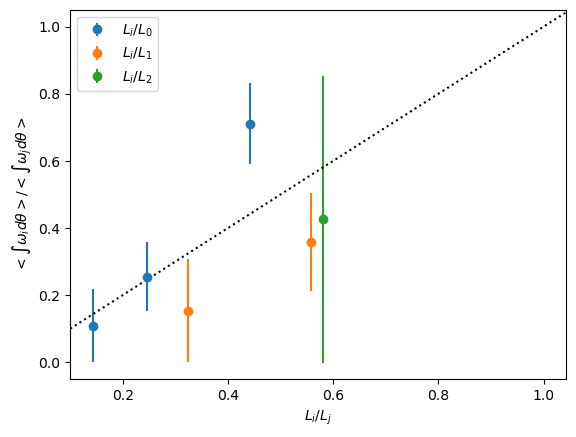

[0.71115824 0.2551276  0.10869562]


In [22]:
from scipy import integrate

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        int[q][i] = integrate.trapezoid( xi_bs[q][i][:-cutoff],x=th[:-cutoff], dx=1.)
        #int[q][i] = integrate.trapezoid(  np.sin(np.deg2rad(th[:-cutoff])) * xi_bs[q][i][:-cutoff],x=th[:-cutoff])

# WRITTEN FOR NQUANT=4
ratio_mean = np.zeros(3)
std_mean = np.zeros(3)
ratio2_mean = np.zeros(2)
std2_mean = np.zeros(2)
ratio3_mean = np.zeros(1)
std3_mean = np.zeros(1)

for i in range(len(ratio_mean)):
    ratio_mean[i] = np.mean(int[i+1])/np.mean(int[0])
    std_mean[i] = np.std(int[i+1])/np.mean(int[0])
for i in range(len(ratio2_mean)):
    ratio2_mean[i] = np.mean(int[i+2])/np.mean(int[1])
    std2_mean[i] = np.std(int[i+2])/np.mean(int[1])
for i in range(len(ratio3_mean)):
    ratio3_mean[i] = np.mean(int[i+3])/np.mean(int[2])
    std3_mean[i] = np.std(int[i+3])/np.mean(int[2])

fig, ax = plt.subplots()

meanMag = np.zeros(nquant)
for q in range(nquant):
    meanMag[q] = np.mean(data[q]['K_abs'])


L_ratio = np.zeros(3)
L_ratio2 = np.zeros(2)
L_ratio3 = np.zeros(1)

for i in range(len(L_ratio)):
    L_ratio[i] = 10**(-.4*(meanMag[i+1]-meanMag[0]))
for i in range(len(L_ratio2)):
    L_ratio2[i] = 10**(-.4*(meanMag[i+2]-meanMag[1]))
for i in range(len(L_ratio3)):
    L_ratio3[i] = 10**(-.4*(meanMag[i+3]-meanMag[2]))

print(L_ratio,ratio_mean)

#ax.scatter(1,1,c='C00')
#for i in range(len(ratio_mean)):
ax.errorbar(L_ratio,ratio_mean,yerr=std_mean,c='C00',fmt='o',label=r'$L_i/L_0$')
ax.errorbar(L_ratio2,ratio2_mean,yerr=std2_mean,c='C01',fmt='o',label=r'$L_i/L_1$')
ax.errorbar(L_ratio3,ratio3_mean,yerr=std3_mean,c='C02',fmt='o',label=r'$L_i/L_2$')

#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)
ax.axline((1,1),slope=1,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_id\theta>/<\int\omega_jd\theta>$')
ax.set_xlabel(r'$L_i/L_j$')

ax.legend()

plotname = f'int_L_nquant{nquant}_nbs{nbootstrap}.png'
#plt.savefig('../plots/'+plotname)

plt.show()

print(ratio_mean)